In [5]:
import numpy as np
import torch  # 导入 PyTorch 库，用于深度学习任务
from PIL import Image  # 导入 PIL 库中的 Image 模块，用于图像处理
import os  # 导入 os 库，用于文件和目录操作

from torch.nn.init import kaiming_normal_
from torch.utils.data import Dataset  # 导入 PyTorch 的 Dataset 类，用于创建自定义数据集
import torchvision.transforms as T  # 导入 torchvision 的 transforms 模块，用于图像预处理
import pandas as pd  # 导入 pandas 库，用于数据处理和分析
import re

In [6]:
classification_names = {
    0:'上身衣服',
    1:'鞋',
    2:'包',
    3:'下身衣服',
    4:'手表',
}

In [7]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split(r'([0-9]+)',key)]
    return sorted(data,key=alphanum_key)

In [10]:
class ImageLabelDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.all_images = sorted_alphanumeric(os.listdir(self.image_dir))
        self.classifications = pd.read_csv("../common/fashion-labels.csv")
        self.label_dict = dict(zip(self.classifications['id'],self.classifications['target']))

    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.all_images[idx])
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            tensor_image = self.transform(image)
        else:
            raise ValueError("transform参数不能为None，需指定预处理方法")
        label = self.label_dict.get(idx)

        return tensor_image,label

In [14]:
import torchvision.transforms as transforms
transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()])
dataset = ImageLabelDataset(image_dir="../common/dataset",transform=transform)
print(len(dataset))
print(dataset[0])

24853
(tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]]), 3)


In [15]:
from torch.utils.data import random_split

# 划分训练集和测试集
train_dataset, test_dataset = random_split(dataset, [0.75, 0.25])
print(len(train_dataset))
print(len(test_dataset))

18640
6213


In [16]:
from torch.utils.data import DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
for x, y in train_loader:
    print(x.shape, x.device)
    print(y.shape, y.device)
    break

torch.Size([32, 3, 64, 64]) cpu
torch.Size([32]) cpu


In [24]:
import torch.nn as nn
class Classification(nn.Module):
    def __init__(self,n_classes=5):
        super(Classification, self).__init__()
        self.conv1 = nn.Conv2d(3, 8,kernel_size=3,padding=1,stride=1)
        self.conv2 = nn.Conv2d(8,16,kernel_size=3,padding=1,stride=1)
        self.pool = nn.MaxPool2d(2,2)
        self.linear = nn.Linear(16**3,n_classes)
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.shape[0], -1)
        x = self.linear(x)
        return x

In [30]:
data_iter = iter(train_loader)
x,y = next(data_iter)
print(x.shape)
print(y.shape)

torch.Size([32, 3, 64, 64])
torch.Size([32])


In [31]:
model = Classification()
out = model(x)
print(out.shape)

torch.Size([32, 5])


In [32]:
# 训练
device = torch.device('mps' if torch.cuda.is_available() else 'cpu')
# 定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 10
for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        loss = loss_fn(output, y)
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
    avg_loss = total_loss / len(train_loader)
    print("epoch:{}, loss:{}".format(epoch, avg_loss))

epoch:1, loss:0.20742384029417923
epoch:2, loss:0.07477229077093338
epoch:3, loss:0.05684548954848845
epoch:4, loss:0.045906473680982336
epoch:5, loss:0.03862966191844396
epoch:6, loss:0.03344704960897875
epoch:7, loss:0.027084375215060276
epoch:8, loss:0.024527821957716887
epoch:9, loss:0.020450779209605786
epoch:10, loss:0.017948835543988607


In [33]:
 #验证模型效果
# 从测试数据加载器获取一个批次图像数据
loder_iter = iter(test_loader)
x,y = next(loder_iter)
print(x.shape)
print(y.shape)

torch.Size([32, 3, 64, 64])
torch.Size([32])


In [35]:
model.to(device)
x,y = x.to(device), y.to(device)
out = model(x)
out = out.detach().cpu().numpy()
print(out.shape)
x = x.permute(0,2,3,1).detach().cpu().numpy()
print(x.shape)

(32, 5)
(32, 64, 64, 3)


1-out:上身衣服
1-out:上身衣服
2-out:上身衣服
2-out:上身衣服
3-out:上身衣服
3-out:上身衣服
4-out:上身衣服
4-out:上身衣服
5-out:上身衣服
5-out:上身衣服
6-out:上身衣服
6-out:上身衣服
7-out:上身衣服
7-out:上身衣服
8-out:手表
8-out:手表
9-out:上身衣服
9-out:上身衣服
10-out:下身衣服
10-out:下身衣服


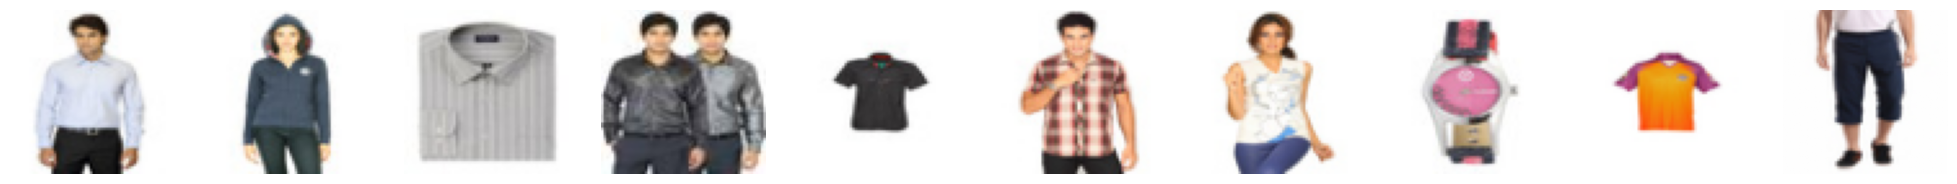

In [48]:
import matplotlib.pyplot as plt
import numpy as np
fig,axes = plt.subplots(1,10,figsize=(25,4))
for i,ax in enumerate(axes):
    ax.imshow(x[i])
    ax.axis('off')
    print(f"{i+1}-out:{classification_names[y[i].item()]}")
    y_pred = np.argmax(out[i])

    print(f"{i+1}-out:{classification_names[y_pred]}")

plt.show()

In [51]:
# 计算准确率
test_correct_num = 0
model.eval().to(device)
with torch.no_grad():
    for x,y in test_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        pred = out.argmax(dim=1)
        test_correct_num += pred.eq(y).sum().item()
print(f"模型测试准确率为：{test_correct_num/len(test_dataset)}")

模型测试准确率为：0.987928536938677
